In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
root = r"my_path"

# basic stat

In [3]:
bi_df = pd.read_csv(os.path.join(root, r"country_bipartite.csv"))

In [4]:
country_df = pd.read_csv(os.path.join(root, r"country_bipartite.csv"))[["journal_name_wos","reviewer_id"]]
a = country_df.groupby(["journal_name_wos"])["reviewer_id"].nunique().reset_index()
high_degree_list = list(a.loc[a["reviewer_id"] >= 5, "journal_name_wos"].unique())

In [5]:
based_df = bi_df.loc[bi_df["journal_name_wos"].isin(high_degree_list),["journal_name_wos","reviewer_id"]]
based_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1011632 entries, 3 to 1018081
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype
---  ------            --------------    -----
 0   journal_name_wos  1011632 non-null  int64
 1   reviewer_id       1011632 non-null  int64
dtypes: int64(2)
memory usage: 23.2 MB


In [6]:
# run this if only count journals in network
node_df = pd.read_csv(os.path.join(root, r"over10_node_list_nonull.csv"))
ids = node_df["Id"].unique()
based_df = based_df[based_df["journal_name_wos"].isin(ids)]
df_reviewer_num = a.query('journal_name_wos in @ ids')
based_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006846 entries, 3 to 1018081
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype
---  ------            --------------    -----
 0   journal_name_wos  1006846 non-null  int64
 1   reviewer_id       1006846 non-null  int64
dtypes: int64(2)
memory usage: 23.0 MB


In [7]:
len(based_df["journal_name_wos"].unique())

6058

In [8]:
len(based_df["reviewer_id"].unique())

477684

In [9]:
df_reviewer_num["reviewer_id"].describe()

count     6058.000000
mean       166.201056
std        516.256241
min          5.000000
25%         11.000000
50%         41.000000
75%        169.000000
max      26278.000000
Name: reviewer_id, dtype: float64

In [10]:
based_df

,journal_name_wos,reviewer_id
3,10001,582
4,10001,940
5,10001,941
6,10001,1141
7,10001,1390
...,...,...
1018077,9990,508400
1018078,9990,509553
1018079,9990,513488
1018080,9990,513585


In [13]:
# share reviewer number

review_num = based_df.groupby("reviewer_id")["journal_name_wos"].nunique()
shared_reviewer_id = review_num[review_num>1].index
copy_bdf = based_df.copy()
copy_bdf["isShared"] = copy_bdf["reviewer_id"].isin(shared_reviewer_id)
shared_num = copy_bdf.groupby("journal_name_wos")["isShared"].sum()
print(shared_num.mean(), shared_num.std(), shared_num.median())

118.99273687685705 351.021462744541 30.0


In [13]:
# skewed reviewer distribution

top_5_perc = df_reviewer_num.nlargest(n=int(len(df_reviewer_num)*0.05),columns=["reviewer_id"])
print(len(top_5_perc))
print(top_5_perc["reviewer_id"].sum(), top_5_perc["reviewer_id"].sum()/df_reviewer_num["reviewer_id"].sum())
k = based_df.loc[based_df["journal_name_wos"].isin(top_5_perc["journal_name_wos"].unique()), "reviewer_id"].unique()
print(len(k), len(k)/len(based_df["reviewer_id"].unique())) #unique reviewer
top_5_perc["reviewer_id"].describe()

302
421556 0.4186896506516389
261104 0.5466040311168052


count      302.000000
mean      1395.880795
std       1843.398211
min        677.000000
25%        789.250000
50%       1021.500000
75%       1366.000000
max      26278.000000
Name: reviewer_id, dtype: float64

In [14]:
below_10 = df_reviewer_num[df_reviewer_num["reviewer_id"] < 10]
print(len(below_10), len(below_10)/len(df_reviewer_num))
k = based_df.loc[based_df["journal_name_wos"].isin(below_10["journal_name_wos"].unique()), "reviewer_id"].unique()
print(len(k), len(k)/len(based_df["reviewer_id"].unique())) #unique reviewer

1279 0.2111257840871575
6234 0.013050468510563469


In [8]:
# plot a culumative distribution of unique reviewers

df_ecdf = df_reviewer_num.sort_values('reviewer_id', ascending=False)
journals = df_ecdf['journal_name_wos'].tolist()
# record unique reviewers
uni_reviewer_counts = []
for i in range(len(journals)):        
    window = journals[:i+1]
    k = based_df.loc[based_df["journal_name_wos"].isin(window), "reviewer_id"].nunique()
    uni_reviewer_counts.append(k)
    
df_ecdf['uni_reviewer'] = uni_reviewer_counts
df_ecdf['% uni_reviewer'] = df_ecdf['uni_reviewer'] / uni_reviewer_counts[-1]
df_ecdf['% journals'] = np.linspace(1 / len(journals), 1, len(journals))
df_ecdf

,journal_name_wos,reviewer_id,uni_reviewer,% uni_reviewer,% journals
8437,21456,26278,26278,0.055011,0.000165
7966,20231,13043,39240,0.082146,0.000330
7486,19450,11006,49563,0.103757,0.000495
8873,22123,6914,56048,0.117333,0.000660
8393,21377,4922,60699,0.127069,0.000825
...,...,...,...,...,...
7273,19121,5,477683,0.999998,0.999340
8678,21812,5,477683,0.999998,0.999505
8313,21261,5,477684,1.000000,0.999670
6596,15184,5,477684,1.000000,0.999835


In [10]:
fig = px.line(df_ecdf, x='% journals', y='% uni_reviewer')
fig.update_layout(height=400,width=500,
                  font=dict(family='Arial'),
                  template='simple_white')
fig.update_xaxes(tickformat= ',.0%',
                 showgrid=True,
                 minor=dict(showgrid=True),
                 )
fig.update_yaxes(tickformat= ',.0%',
                 showgrid=True,
                 minor=dict(showgrid=True),
                 title=dict(text='% unique reviewers',
                            standoff=0
                            )
                 )
fig.write_image('lorentz.pdf')

each reviewer is linked with 2.11±2.39, median 1.00 journals


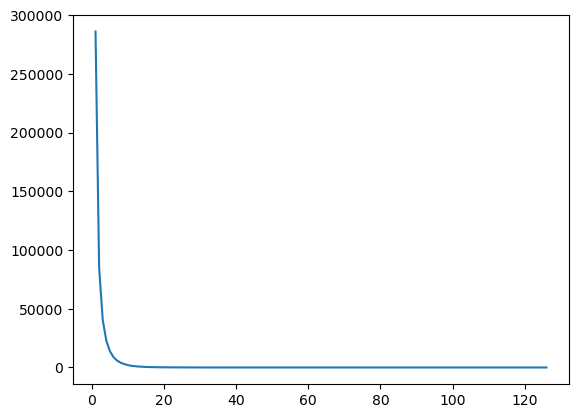

In [14]:
# Journal distribution across reviewers
a = based_df.groupby(["reviewer_id"])["journal_name_wos"].nunique().reset_index()
b = a.groupby(["journal_name_wos"])["reviewer_id"].size()
x = b.index
y = b.values
print("each reviewer is linked with {:.2f}±{:.2f}, median {:.2f} journals".format(a["journal_name_wos"].mean(), a["journal_name_wos"].std(), a["journal_name_wos"].median()))

fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

# reviewers' gender

In [18]:
gender_df = pd.read_csv(os.path.join(root, r"gender_bipartite.csv"))
based_g_df = pd.merge(based_df, gender_df, on="reviewer_id", how="left")
based_g_df

,journal_name_wos,reviewer_id,gender_final
0,10001,582,NaN
1,10001,940,M
2,10001,941,NaN
3,10001,1141,NaN
4,10001,1390,NaN
...,...,...,...
1006841,9990,508400,F
1006842,9990,509553,NaN
1006843,9990,513488,NaN
1006844,9990,513585,M


In [19]:
a =based_g_df.loc[~based_g_df["gender_final"].isna(), "reviewer_id"].unique() #identified gender
b =based_g_df.loc[based_g_df["gender_final"]=="M", "reviewer_id"].unique()
c =based_g_df.loc[based_g_df["gender_final"]=="F", "reviewer_id"].unique()
for d in [a,b,c]:
    print(len(d))

203976
141728
62248


In [20]:
# calculate number of journals reviewed by gender
keyCol = "journal_name_wos"
f1 = (based_g_df[~based_g_df["gender_final"].isna()]
      .groupby(["reviewer_id","gender_final"])[keyCol]
      .nunique()
      .reset_index()
     )
#f1.to_csv(os.path.join(root, r"reviewer_gender/{}_gender_reviewed.csv".format(keyCol)))
print(f1.groupby(["gender_final"])[keyCol].mean())
print(f1.groupby(["gender_final"])[keyCol].std())

gender_final
F    2.333055
M    2.746126
Name: journal_name_wos, dtype: float64
gender_final
F    2.372920
M    3.239703
Name: journal_name_wos, dtype: float64


In [21]:
# calculate female rates for each journal

identified_g_df = based_g_df.loc[~based_g_df["gender_final"].isna()]
identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})

# keep journals occurring >5 times 
a = identified_g_df["journal_name_wos"].value_counts()
a = a[a> 5]
b = a.index
identified_g_df = identified_g_df[identified_g_df["journal_name_wos"].isin(b)]

female_rate_df = identified_g_df.groupby("journal_name_wos").apply(lambda x: x["is_female"].sum()/len(x)).reset_index()
female_rate_df["Gender"] = "Female"
male_rate_df = identified_g_df.groupby("journal_name_wos").apply(lambda x: 1-x["is_female"].sum()/len(x)).reset_index()
male_rate_df["Gender"] = "Male"
ab = pd.concat([female_rate_df,male_rate_df], axis=0, ignore_index = True)
ab = ab.rename(columns={0:"Percentage"})
ab["Percentage"] = ab["Percentage"]*100
ab

C:\Users\Zheng\AppData\Local\Temp\ipykernel_20980\3496972139.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


,journal_name_wos,Percentage,Gender
0,9,40.000000,Female
1,12,24.752475,Female
2,21,29.310345,Female
3,22,56.250000,Female
4,28,12.500000,Female
...,...,...,...
10123,22610,53.030303,Male
10124,22612,41.176471,Male
10125,22621,68.965517,Male
10126,22622,65.853659,Male


In [22]:
len(ab["journal_name_wos"].unique())

5064

In [24]:
valcount = (ab
            .loc[ab["Gender"]=="Female","Percentage"]
            .value_counts()
            .reset_index())
valcount

,index,Percentage
0,0.000000,321
1,33.333333,150
2,16.666667,148
3,25.000000,126
4,14.285714,126
...,...,...
1791,12.380952,1
1792,15.527950,1
1793,12.053571,1
1794,11.525424,1


In [26]:
cut_df = pd.cut(valcount["index"], bins=50)
valcount["cut"] = cut_df
a = valcount.groupby("cut")["Percentage"].sum()
a

cut
(-0.1, 2.0]      322
(2.0, 4.0]        14
(4.0, 6.0]        52
(6.0, 8.0]       100
(8.0, 10.0]      172
(10.0, 12.0]     185
(12.0, 14.0]     254
(14.0, 16.0]     337
(16.0, 18.0]     325
(18.0, 20.0]     294
(20.0, 22.0]     197
(22.0, 24.0]     264
(24.0, 26.0]     271
(26.0, 28.0]     237
(28.0, 30.0]     307
(30.0, 32.0]     205
(32.0, 34.0]     255
(34.0, 36.0]     135
(36.0, 38.0]     151
(38.0, 40.0]     156
(40.0, 42.0]      82
(42.0, 44.0]     100
(44.0, 46.0]      79
(46.0, 48.0]      61
(48.0, 50.0]      94
(50.0, 52.0]      24
(52.0, 54.0]      42
(54.0, 56.0]      40
(56.0, 58.0]      49
(58.0, 60.0]      39
(60.0, 62.0]      19
(62.0, 64.0]      28
(64.0, 66.0]      20
(66.0, 68.0]      28
(68.0, 70.0]      14
(70.0, 72.0]      19
(72.0, 74.0]      16
(74.0, 76.0]      15
(76.0, 78.0]      14
(78.0, 80.0]      10
(80.0, 82.0]       5
(82.0, 84.0]      10
(84.0, 86.0]       7
(86.0, 88.0]       4
(88.0, 90.0]       3
(90.0, 92.0]       1
(92.0, 94.0]       2
(94.0, 96

In [27]:
ab.to_csv(os.path.join(root,"journal_gender_percentage.csv"), index=False)

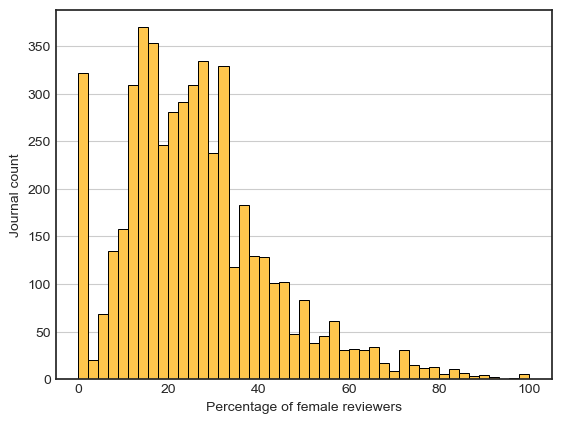

In [28]:
ab = pd.read_csv(os.path.join(root,"journal_gender_percentage.csv"))
plt.style.use("seaborn-white")
fig, ax = plt.subplots(1,1)
colors = ["#FEC64D"] #, "#009FC3"
ab=ab.rename(columns={"Percentage": "Percentage of female reviewers"})
sns.histplot(data=ab[ab["Gender"]=="Female"],
             x="Percentage of female reviewers",
             hue="Gender",
             ax=ax, palette=colors,
             alpha=1,
            legend=False)
ax.grid(axis="y")
ax.set_ylabel("Journal count")
plt.show()

In [29]:
len(ab[ab["Gender"]=="Female"]),len(ab[ab["Gender"]=="Male"])

(5064, 5064)

In [30]:
ab.loc[ab["Gender"]=="Female","Percentage of female reviewers"].value_counts()

0.000000     321
33.333333    150
16.666667    148
25.000000    126
14.285714    126
            ... 
12.380952      1
15.527950      1
12.053571      1
11.525424      1
34.146341      1
Name: Percentage of female reviewers, Length: 1796, dtype: int64

# reviewers' country

In [13]:
ctry_df = pd.read_csv(os.path.join(root, r"reviewer_country.csv"))
based_c_df = pd.merge(based_df, ctry_df, on="reviewer_id", how="left")
based_c_df

,journal_name_wos,reviewer_id,alpha2
0,10001,582,FR
1,10001,940,IN
2,10001,941,CN
3,10001,1141,NaN
4,10001,1390,IN
...,...,...,...
1006841,9990,508400,US
1006842,9990,509553,NaN
1006843,9990,513488,NaN
1006844,9990,513585,US


In [21]:
a = (based_c_df[["reviewer_id", "alpha2"]]
 .drop_duplicates()
 .dropna()
 .groupby("alpha2")["reviewer_id"].nunique()
 .sort_values(ascending=False)
 .reset_index()
    )
sum_reviewer = sum(a["reviewer_id"])
a["perc"] = a["reviewer_id"] / sum_reviewer
a.head(10)

,alpha2,reviewer_id,perc
0,US,41247,0.164237
1,CN,26552,0.105725
2,GB,15209,0.060559
3,ES,12521,0.049856
4,BR,12272,0.048865
5,IT,11846,0.047168
6,IN,11500,0.045791
7,AU,11316,0.045058
8,JP,7220,0.028749
9,DE,6746,0.026861


In [21]:
country_df = pd.read_excel(os.path.join(root,"country_classification.xlsx"))
#pd.merge(a, country_df[["alpha2","reviewer_country"]].drop_duplicates(), on="alpha2").to_excel("reviewr_country_count.xlsx")

In [22]:
# calculate number of journals reviewed by country


keyCol = "journal_name_wos"
f1 = (based_c_df[~based_c_df["alpha2"].isna()]
      .groupby(["reviewer_id","alpha2"])[keyCol]
      .nunique()
      .reset_index()
     )
#f1.to_csv(os.path.join(root, r"reviewer_gender/{}_gender_reviewed.csv".format(keyCol)))
a = a.set_index("alpha2")
pd.concat([f1.groupby(["alpha2"])[keyCol].mean(),
            f1.groupby(["alpha2"])[keyCol].std(), a], axis=1).to_csv(r"ctry_journal_reviewed.csv")

In [23]:
# group by continent

cont_df = (pd.merge(a, country_df[["alpha2","continent"]].drop_duplicates(), on="alpha2")
 .groupby("continent")["reviewer_id"].sum()
 .reset_index()
)
cont_df

,continent,reviewer_id
0,Africa,7288
1,Asia,71952
2,Europe,93623
3,North America,50406
4,Oceania,13316
5,South America,15221


In [24]:
f1 = (pd.merge(based_c_df, country_df[["alpha2","continent"]].drop_duplicates(), on="alpha2")
     .groupby(["reviewer_id","continent"])["journal_name_wos"].nunique()
      .reset_index()
     .reset_index()
    )
pd.concat([f1.groupby(["continent"])[keyCol].mean(),
            f1.groupby(["continent"])[keyCol].std()], axis=1)

,journal_name_wos,journal_name_wos
continent,,
Africa,1.621430,1.445685
Asia,2.233044,2.592086
Europe,2.755455,3.231665
North America,2.750248,2.948020
Oceania,3.080054,3.342673
South America,2.125287,2.171674


# co-reviewer network

In [11]:
# get node list
g_df = pd.read_csv(os.path.join(root, r"over10_edge_list_nonull.csv"))
# edge number
len(g_df)

595267

In [12]:
g_df

,source,target,weight
0,9,76,1
1,9,78,1
2,9,109,1
3,9,276,1
4,9,389,1
...,...,...,...
595262,22558,22583,1
595263,22564,22570,1
595264,22565,22569,1
595265,22573,22622,1


In [13]:
# build a network

G = nx.from_pandas_edgelist(g_df, 'source', 'target', edge_attr='weight')

In [10]:
# average linked journal/weighted degree
a = np.array(list(dict(G.degree()).values()))
b = np.array(list(dict(G.degree(weight="weight")).values()))
df_describe = pd.DataFrame(a)
df_describe.describe()

,0
count,6058.000000
mean,196.522615
std,219.769727
min,1.000000
25%,65.000000
50%,131.000000
75%,253.000000
max,4425.000000


In [14]:
# component/connectivity
nx.number_connected_components(G)

1

In [15]:
n_df = pd.read_csv(os.path.join(root, r"over10_node_list_nonull.csv"))
n_df

,Id,alpha2_journal,country_group,did,d1,d2,d3,totalpubs,oapubs,oa_rate,Label,quartile,isOA
0,9,US,1.0,58,Natural Sciences and Engineering,Clinical Medicine,Pharmacology,2989,574,0.192037,AAPS PHARMS,3.0,N
1,12,AU,1.0,132,Social Sciences and Humanities,Professional Fields,Management,557,12,0.021544,ABACUS,3.0,N
2,17,US,1.0,89,Natural Sciences and Engineering,Mathematics,General Mathematics,4452,2388,0.536388,ABSTR APP A,4.0,N
3,21,US,1.0,44,Natural Sciences and Engineering,Clinical Medicine,General & Internal Medicine,5837,144,0.024670,ACAD EM MED,1.0,N
4,22,US,1.0,49,Natural Sciences and Engineering,Clinical Medicine,Miscellaneous Clinical Medicine,11491,240,0.020886,ACAD MED,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,15425,GB,1.0,136,Social Sciences and Humanities,Professional Fields,Education,1627,7,0.004302,SYSTEM,1.0,N
6054,22149,IE,1.0,144,Social Sciences and Humanities,Humanities,Religion,294,1,0.003401,IR THEOL Q,3.0,N
6055,21131,GB,1.0,143,Social Sciences and Humanities,Humanities,Miscellaneous Humanities,322,3,0.009317,ARCH REC,2.0,N
6056,20970,US,1.0,141,Social Sciences and Humanities,Humanities,History,585,2,0.003419,ORAL HIST R,1.0,N


# weighted centrality measures

In [16]:
g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, g_distance_dict, 'distance')

In [ ]:
cc_list = nx.closeness_centrality(G, distance="distance", wf_improved=True)
cc_list

In [ ]:
ec_list = nx.eigenvector_centrality(G, weight="weight")
ec_list

In [ ]:
bc_list = nx.betweenness_centrality(G, normalized=True, weight="distance")
bc_list

In [27]:
cc = pd.DataFrame.from_dict(cc_list, orient="index",columns=["closeness"])
ec = pd.DataFrame.from_dict(ec_list, orient="index",columns=["eigen"])
bc = pd.DataFrame.from_dict(bc_list, orient="index",columns=["betweenness"])
cent_df = pd.concat([cc,ec,bc], axis=1)
cent_df.to_csv(os.path.join(root, r"weighted_centrality.csv"))

# exlusive reviewers

In [106]:
# drop all duplicate reviewers

exclusive_df = based_df[~based_df.duplicated("reviewer_id", keep=False)]
(exclusive_df
 .groupby("journal_name_wos")["reviewer_id"]
 .nunique()
 .reset_index()
 .rename(columns={"reviewer_id":"exlusive_reviewer_number"})
 .to_csv(os.path.join(root, r"exlusive_reviewer_number.csv")))

# by discipline

In [12]:
disc_df = n_df[["Id","d2"]]
disc_attr = disc_df.set_index("Id").to_dict()["d2"]
nx.set_node_attributes(G,disc_attr, name="disc")

In [13]:
def calculateDegreeJournal(attr = "disc"):
    j_count = {} # journal count
    d_count = {} # degree count
    field_dict = [] # for making table
    for node in list(G.nodes(data=True)):
        if len(node) == 2:
            disc = node[1][attr]
            j_count.update({disc: j_count.get(disc, 0) + 1})
            d_count.update({disc: d_count.get(disc, 0) + G.degree(node[0], weight="weight")})
            field_dict.append((disc, G.degree(node[0], weight="weight")))
        else:
            print(node)
    (pd.DataFrame(field_dict,
                  columns=["Field","Weighted degree"])
     .to_csv(os.path.join(root, r"degree/{}_degree.csv".format(attr)),
             index=False))
    return j_count, d_count

j_count, d_count = calculateDegreeJournal(attr = "disc")

In [16]:
d_count

{'Clinical Medicine': 1031998,
 'Engineering and Technology': 655853,
 'Chemistry': 143151,
 'Physics': 205920,
 'Biomedical Research': 584867,
 'Biology': 494585,
 'Mathematics': 46600,
 'Professional Fields': 118791,
 'Social Sciences': 169250,
 'Earth and Space': 147963,
 'Psychology': 113081,
 'Health': 111723,
 'Humanities': 9368,
 'Arts': 1002}

In [14]:
# count average reviewers by disc
based_d_df = pd.merge(based_df, disc_df, left_on="journal_name_wos", right_on="Id")
t3 = based_d_df.groupby("journal_name_wos")["reviewer_id"].nunique()

t3

journal_name_wos
9         18
12       174
17         6
21       347
22       374
        ... 
22622    169
22625      5
22627      5
22632      5
22637      9
Name: reviewer_id, Length: 6058, dtype: int64

In [18]:
# count group-exclusive reviewer number

def countExclusiveUniquePerc(keyCol="d2"):
    reviewer_group_count = (based_d_df
                             .groupby("reviewer_id")[keyCol]
                             .nunique())
    reviewer_group_count = reviewer_group_count[reviewer_group_count==1]
    g_ex_reviewer = reviewer_group_count.index
    a = based_d_df[based_d_df["reviewer_id"].isin(g_ex_reviewer)]
    g_reviewer_count = based_d_df.groupby(keyCol)["reviewer_id"].nunique()
    g_ex_reviewer_count = a.groupby(keyCol)["reviewer_id"].nunique()
    merged = pd.concat([g_reviewer_count,g_ex_reviewer_count], axis=1)
    merged.columns=["Unique reviewers","Exclusive reviewers"]
    merged["Perc"] = merged["Exclusive reviewers"] / merged["Unique reviewers"] *100
    return merged

g_ex_reviewer=countExclusiveUniquePerc(keyCol="d2")

In [19]:
# count exclusive reviewers

def calculateExclusive(keyCol="d2"): # d2 or alpha2
    ex_df = pd.read_csv(os.path.join(root, "exlusive_reviewer_number.csv"))
    based_ex = pd.merge(based_d_df[["journal_name_wos", keyCol]].drop_duplicates("journal_name_wos"),
                        ex_df,
                        on="journal_name_wos",
                        how="left")
    based_ex = pd.merge(based_ex,
                        t3,
                        on="journal_name_wos",
                        how="left")
    based_ex["exlusive_reviewer_number"] = based_ex["exlusive_reviewer_number"].fillna(0)
    based_ex["ex_perc"] = based_ex["exlusive_reviewer_number"]/based_ex["reviewer_id"]*100
    based_ex.to_csv(os.path.join(root, r"reviewer_stat/{}_reviewer.csv".format(keyCol)),
             index=False)
    based_ex= based_ex.groupby(keyCol)[["exlusive_reviewer_number","reviewer_id","ex_perc"]].mean()
    return based_ex

ex_reviewer= calculateExclusive(keyCol="d2")
ex_reviewer

,exlusive_reviewer_number,reviewer_id,ex_perc
d2,,,
Arts,23.444444,42.833333,58.055921
Biology,39.933444,175.765391,16.726587
Biomedical Research,38.161179,190.485269,13.186969
Chemistry,35.934109,124.217054,15.874192
Clinical Medicine,52.775179,181.124107,19.214976
Earth and Space,33.900293,107.744868,18.936255
Engineering and Technology,70.895307,236.701564,20.703994
Health,51.139442,152.517928,27.501310
Humanities,25.636364,51.209091,52.698829


In [14]:
#clustering coefficient

#function to list all nodes in a subgraph of a field
def genSubNodeList(field, attr = "disc"):
    nodes = (
        node
        for node, data
        in G.nodes(data=True)
        if data.get(attr) == field
    )
    return list(nodes)

genSubNodeList(field="Arts", attr = "disc")

[8146,
 9447,
 16016,
 11682,
 18927,
 7163,
 8519,
 15298,
 7388,
 13923,
 13177,
 21116,
 9675,
 3920,
 4469,
 21048,
 6405,
 8139]

In [21]:
# def calculateCC(fields, attr):
#     cc_dict = {}
#     for field in fields:
#         sub_nodes = genSubNodeList(field, attr = attr)
#         if len(sub_nodes) >5:
#             sub_graph = G.subgraph(sub_nodes)
#             cc = nx.average_clustering(sub_graph, weight="weight", count_zeros=True)
#             print(field, cc)
#             cc_dict.update({field:cc})
#     return cc_dict

# fields = list(n_df["d2"].unique()) # list of fields
# cc_dict=calculateCC(fields, attr="disc")

In [15]:
# calculate average intra-group degree percentage

def calculateInGroupDgPerc(fields, attr = "disc"):
    avg_perc = {}
    field_dict = [] # used for making table

    for field in fields:
        field_avg_perc = []
        sub_nodes = genSubNodeList(field, attr = attr)

        for sub_node in sub_nodes:
            intra_dg = 0
            inter_dg = 0
            for source, target, weight in G.edges(sub_node, data=True):
                try:
                    target_field = G.nodes[target][attr]
                    if target_field == field:
                        intra_dg += weight["weight"]
                    else:
                        inter_dg += weight["weight"]
                except Exception as e:
                    print(e)
                    continue
            if intra_dg+inter_dg > 0:
                ratio = intra_dg/(intra_dg+inter_dg)
                field_avg_perc.append(ratio)
                field_dict.append((sub_node, field,ratio))

        avg_perc.update({field: np.array(field_avg_perc).mean()*100})
    (pd.DataFrame(field_dict,
                  columns=["node_id", "Field","% intra-group weighted degree"])
     .to_csv(os.path.join(root, r"intra-group/{}_intra_group.csv".format(attr)),
             index=False))
    
    return avg_perc

In [16]:
fields = list(n_df["d2"].unique()) # list of fields
avg_perc = calculateInGroupDgPerc(fields, attr = "disc")
avg_perc

{'Clinical Medicine': 65.95491788964759,
 'Professional Fields': 50.84239210091227,
 'Mathematics': 32.58934131785894,
 'Psychology': 39.172869572677556,
 'Chemistry': 38.09980901929427,
 'Engineering and Technology': 62.145081188698406,
 'Physics': 45.211960183062494,
 'Biomedical Research': 39.01254144412211,
 'Biology': 56.46448689751602,
 'Earth and Space': 44.27317307600859,
 'Social Sciences': 61.11662426596013,
 'Health': 31.73983694404753,
 'Humanities': 35.41518215930179,
 'Arts': 3.3939276970955548}

In [24]:
# calculate avg female gender percentage

def calculateFemalePerc(keyCol="d2"): # d2 or alpha2
    gender_perc_df = pd.read_csv(os.path.join(root, "journal_gender_percentage.csv"))
    gender_perc_df = gender_perc_df[gender_perc_df["Gender"] == "Female"]
    based_gender = pd.merge(based_d_df[["journal_name_wos", keyCol]].drop_duplicates("journal_name_wos"),
                        gender_perc_df,
                        on="journal_name_wos")
    based_gender.to_csv(os.path.join(root, r"reviewer_gender/{}_reviewer_gender.csv".format(keyCol)),index=False)
    t4 = based_gender.groupby(keyCol)["Percentage"].mean()
    return t4

In [25]:
t4 = calculateFemalePerc(keyCol="d2")
t4

d2
Arts                          43.969030
Biology                       23.866579
Biomedical Research           23.796544
Chemistry                     15.486088
Clinical Medicine             27.000496
Earth and Space               19.949708
Engineering and Technology    14.111267
Health                        50.187752
Humanities                    36.057304
Mathematics                   15.117464
Physics                       13.499245
Professional Fields           39.934301
Psychology                    39.887844
Social Sciences               33.647688
Name: Percentage, dtype: float64

In [25]:
# calculate all reviewer/ exclusive reviewer female percentage

# based_d_df: reviewer table; g_ex_reviewer_df: exclusive
def calculateGroupGenderPerc(keyCol = "d2"):
    reviewer_group_count = (based_d_df
                             .groupby("reviewer_id")[keyCol]
                             .nunique())
    reviewer_group_count = reviewer_group_count[reviewer_group_count==1]
    g_ex_reviewer = reviewer_group_count.index
    g_ex_reviewer_df = based_d_df[based_d_df["reviewer_id"].isin(g_ex_reviewer)]

    # gender table
    gender_df = pd.read_csv(os.path.join(root, r"gender_bipartite.csv"))
    based_g_df = pd.merge(based_df, gender_df, on="reviewer_id", how="left")
    identified_g_df = based_g_df.loc[~based_g_df["gender_final"].isna()]
    identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})

    # join
    f1 = (pd.merge(based_d_df[["reviewer_id", keyCol]].drop_duplicates(),
                 identified_g_df[["reviewer_id", "is_female"]].drop_duplicates(),
                 on = "reviewer_id"
                )
         .groupby(keyCol)["is_female"]
         .apply(lambda x: sum(x) / len(x)))
    f2 = (pd.merge(g_ex_reviewer_df[["reviewer_id", keyCol]].drop_duplicates(),
                 identified_g_df[["reviewer_id", "is_female"]].drop_duplicates(),
                 on = "reviewer_id"
                 )
         .groupby(keyCol)["is_female"]
         .apply(lambda x: sum(x) / len(x))
         )

    a = pd.concat([f1, f2], axis=1)
    a.columns = ["reviewer","exlusive_reviewer"]
    a.to_csv(os.path.join(root, r"reviewer_gender/{}_group_gender.csv".format(keyCol)))
    return a

group_gender=calculateGroupGenderPerc(keyCol = "d2")
group_gender

C:\Users\23645\AppData\Local\Temp\ipykernel_10808\469345545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


,reviewer,exlusive_reviewer
d2,,
Arts,0.390582,0.429487
Biology,0.312262,0.339914
Biomedical Research,0.293304,0.340231
Chemistry,0.216950,0.236406
Clinical Medicine,0.346361,0.349562
Earth and Space,0.258723,0.285990
Engineering and Technology,0.171588,0.171046
Health,0.534950,0.627984
Humanities,0.327404,0.352882


In [26]:
# calculate each reviewer gender's reviewed discipline
def calculateGenderReviewed(keyCol = "d2"):
    reviewer_group_count = (based_d_df
                             .groupby("reviewer_id")[keyCol]
                             .nunique())
    reviewer_group_count = reviewer_group_count[reviewer_group_count==1]

    # gender table
    gender_df = pd.read_csv(os.path.join(root, r"gender_bipartite.csv"))
    based_g_df = pd.merge(based_df, gender_df, on="reviewer_id", how="left")
    identified_g_df = based_g_df.loc[~based_g_df["gender_final"].isna()]
    identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})

    # join
    f1 = (pd.merge(based_d_df[["reviewer_id", keyCol]].drop_duplicates(),
                 identified_g_df[["reviewer_id", "is_female"]].drop_duplicates(),
                 on = "reviewer_id"
                )
          .groupby(["reviewer_id","is_female"])[keyCol]
          .nunique()
          .reset_index()
         )
    f1.to_csv(os.path.join(root, r"reviewer_gender/{}_gender_reviewed.csv".format(keyCol)))
    return f1.groupby(["is_female"])[keyCol].mean()

calculateGenderReviewed(keyCol = "d2")

C:\Users\23645\AppData\Local\Temp\ipykernel_10808\1301170056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


is_female
0    1.419268
1    1.370004
Name: d2, dtype: float64

In [16]:
# calculate gini coefficient of country; only use top 50 countries

#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

def calcGini(keyCol = "d2", isNorm = False):
    reviewer_ctry_df = pd.read_csv(os.path.join(root, "reviewer_country.csv"))
    # top 50
    temp = reviewer_ctry_df.groupby("alpha2")["reviewer_id"].nunique()
    top50 = temp[temp>=500].index
    based_d_df2 = pd.merge(based_d_df, reviewer_ctry_df, on="reviewer_id")
    gini_numer = pd.pivot_table(based_d_df2,
                               values="reviewer_id",
                               index=keyCol,
                               columns="alpha2",
                               aggfunc=lambda x:len(x.unique()),
                               fill_value=0
                              )
    if isNorm:
        gini_denom = pd.pivot_table(based_d_df2,
                                   values="reviewer_id",
                                   index="alpha2",
                                   aggfunc=lambda x:len(x.unique()),
                                   fill_value=0
                                  ).squeeze()
        gini_base = gini_numer.divide(gini_denom, axis=1)
    else:
        gini_base = gini_numer
    gini_base = gini_base[top50]
    gini_base.T.to_csv("gini_base_{}.csv".format(keyCol))
    a1 = gini_base.apply(lambda x:gini(x), axis=1)
    
    # exclusive
    reviewer_group_count = (based_d_df
                             .groupby("reviewer_id")[keyCol]
                             .nunique())
    reviewer_group_count = reviewer_group_count[reviewer_group_count==1]
    g_ex_reviewer = reviewer_group_count.index
    g_ex_reviewer_df = based_d_df[based_d_df["reviewer_id"].isin(g_ex_reviewer)]
    based_d_df2 = pd.merge(g_ex_reviewer_df, reviewer_ctry_df, on="reviewer_id")

    gini_numer = pd.pivot_table(based_d_df2,
                               values="reviewer_id",
                               index=keyCol,
                               columns="alpha2",
                               aggfunc=lambda x:len(x.unique()),
                               fill_value=0
                              )
    if isNorm:
        gini_denom = pd.pivot_table(based_d_df2,
                                   values="reviewer_id",
                                   index="alpha2",
                                   aggfunc=lambda x:len(x.unique()),
                                   fill_value=0
                                  ).squeeze()
        gini_base = gini_numer.divide(gini_denom, axis=1)
    else:
        gini_base = gini_numer
    gini_base = gini_base[top50]
    gini_base.T.to_csv("gini_exclusive_{}.csv".format(keyCol))
    b1 = gini_base.apply(lambda x:gini(x), axis=1)
    
    c = pd.concat([a1,b1], axis=1)
    c.columns = ["reviewer", "exclusive reviewer"]
    c.to_csv(os.path.join(root, r"reviewer_stat/{}_group_gini.csv".format(keyCol)))
    return c

calcGini(keyCol = "d2", isNorm=True)

,reviewer,exclusive reviewer
d2,,
Arts,0.437590,0.493240
Biology,0.198861,0.246746
Biomedical Research,0.176265,0.181464
Chemistry,0.225531,0.270765
Clinical Medicine,0.160963,0.184211
Earth and Space,0.128162,0.153158
Engineering and Technology,0.239513,0.261836
Health,0.321076,0.335717
Humanities,0.285520,0.358702


In [12]:
# check country percentage change for each discipline
#keyCol = "d2"

def ctryPercChange(keyCol):
    reviewer_ctry_df = pd.read_csv(os.path.join(root, "reviewer_country.csv"))
    based_d_df2 = pd.merge(based_d_df, reviewer_ctry_df, on="reviewer_id")
    gini_numer = pd.pivot_table(based_d_df2,
                               values="reviewer_id",
                               index=keyCol,
                               columns="alpha2",
                               aggfunc=lambda x:len(x.unique()),
                               fill_value=0
                              )
    gini_base = gini_numer.apply(sum, axis=1)
    d = gini_numer.divide(gini_base, axis=0)
    subds = []
    for i in d.index:
        subd = d.loc[i,:].sort_values(ascending=False).head(10).reset_index().rename(columns={i:"perc"})
        subd[keyCol] = i
        subds.append(subd)

    dd1 = pd.concat(subds, ignore_index=True)

    # exclusive
    reviewer_group_count = (based_d_df
                             .groupby("reviewer_id")[keyCol]
                             .nunique())
    reviewer_group_count = reviewer_group_count[reviewer_group_count==1]
    g_ex_reviewer = reviewer_group_count.index
    g_ex_reviewer_df = based_d_df[based_d_df["reviewer_id"].isin(g_ex_reviewer)]
    based_d_df2 = pd.merge(g_ex_reviewer_df, reviewer_ctry_df, on="reviewer_id")

    gini_numer = pd.pivot_table(based_d_df2,
                               values="reviewer_id",
                               index=keyCol,
                               columns="alpha2",
                               aggfunc=lambda x:len(x.unique()),
                               fill_value=0
                              )
    gini_base = gini_numer.apply(sum, axis=1)
    d2 = gini_numer.divide(gini_base, axis=0)

    subds = []
    for i in d2.index:
        subd = d2.loc[i,:].reset_index().rename(columns={i:"exc_perc"})
        subd[keyCol] = i
        subds.append(subd)

    dd2 = pd.concat(subds, ignore_index=True)

    dd3 = pd.merge(dd1, dd2, on=["alpha2", keyCol], how="left")
    dd3["diff"] = dd3["exc_perc"] - dd3["perc"]
    return dd3

#ctryPercChange(keyCol).to_csv(os.path.join(root, r"reviewer_stat/{}_reviewer_ctry_change.csv".format(keyCol)))

In [29]:
# rearrange the table

t = pd.concat([pd.Series(j_count),
               g_ex_reviewer,
               ex_reviewer,
               pd.Series(d_count),
               #pd.Series(cc_dict),
               pd.Series(avg_perc),
               t4],
              axis=1)
t.columns = ["Journals",
             "Reviewers",
             "Group-exclusive reviewers",
             "Perc. of group-exclusive reviewers",
             "Avg. journal-exclusive reviewers",
             "Avg. reviewers",
             "Avg. perc. of journal-exclusive reviewers",
             "Weighted degree",
             #"avg. clustering coefficient (%)",
             "Avg. intra-group degree",
             "Avg. female reviewer perc."]
#t["avg. clustering coefficient (%)"] = t["avg. clustering coefficient (%)"]*100
t["Avg. weighted degree"] = t["Weighted degree"] / t["Journals"]
t = t.sort_index()
t

NameError: name 't4' is not defined

In [154]:
# modularity
communities = disc_df.groupby("d2")["Id"].apply(lambda x:set(x)).tolist()

nx_comm.modularity(G, communities, weight='weight', resolution=1)

0.4072493304553749

# journals by country

In [17]:
ctry_df = n_df[["Id","alpha2_journal"]]
ctry_attr = ctry_df.set_index("Id").to_dict()["alpha2_journal"]
nx.set_node_attributes(G,ctry_attr, name="ctry")

In [18]:
j_count, d_count = calculateDegreeJournal(attr = "ctry")
j_count

NameError: name 'calculateDegreeJournal' is not defined

In [62]:
d_count

{'US': 1394998,
 'GB': 1599752,
 'CN': 41652,
 'NL': 109157,
 'DE': 134427,
 'NG': 2458,
 'AU': 87187,
 'FR': 12428,
 'CH': 145130,
 'AE': 6112,
 'NZ': 7649,
 'DK': 101334,
 'IT': 12194,
 'KR': 4180,
 'IN': 6636,
 'GR': 3305,
 'CA': 35188,
 'TW': 6704,
 'BR': 25122,
 'TR': 3235,
 'SG': 3500,
 'SE': 10094,
 'PL': 4670,
 'IR': 2240,
 'EG': 1102,
 'SA': 2836,
 'UG': 1948,
 'NO': 9856,
 'JP': 33195,
 'KW': 344,
 'HK': 1365,
 'PT': 132,
 'AT': 4545,
 'HR': 1121,
 'ES': 2193,
 'HU': 713,
 'CL': 279,
 'CO': 225,
 'ZA': 1541,
 'IE': 2908,
 'ET': 249,
 'RS': 638,
 'SK': 922,
 'RO': 450,
 'CZ': 1132,
 'MY': 1914,
 'FI': 1033,
 'KE': 812,
 'PK': 622,
 'CR': 92,
 'BE': 389,
 'RU': 419,
 'MX': 472,
 'BG': 637,
 'EE': 108,
 'JO': 87,
 'LT': 64,
 'MW': 118,
 'SI': 276,
 'TH': 55,
 'PH': 8}

In [18]:
# count unique reviewers/exlusive by ctry

based_d_df = pd.merge(based_df, ctry_df, left_on="journal_name_wos", right_on="Id")
t3 = based_d_df.groupby("journal_name_wos")["reviewer_id"].nunique()
ex_reviewer=calculateExclusive(keyCol="alpha2_journal")
ex_reviewer

NameError: name 'calculateExclusive' is not defined

In [43]:
g_ex_reviewer=countExclusiveUniquePerc(keyCol="alpha2_journal")
g_ex_reviewer

,Unique reviewers,Exclusive reviewers,Perc
alpha2_journal,,,
AE,307,23.0,7.491857
AT,1774,673.0,37.936866
AU,23167,8010.0,34.575042
BE,227,117.0,51.541850
BG,81,13.0,16.049383
...,...,...,...
TR,659,163.0,24.734446
TW,1553,379.0,24.404379
UG,578,222.0,38.408304


In [44]:
# # calculate avg. clustering coef.

# cc_dict = calculateCC(ctrys, attr="ctry")
# cc_dict

In [19]:
ctrys = list(n_df["alpha2_journal"].unique()) # list of fields
avg_perc = calculateInGroupDgPerc(ctrys, attr = "ctry")
avg_perc

{'US': 41.70926618990888,
 'AU': 11.924214990029103,
 'GB': 46.71122287506919,
 'DE': 7.415266878141308,
 'NO': 0.7038401039401782,
 'DK': 12.125740735440143,
 'CN': 2.0572613872020473,
 'BR': 15.480071853479021,
 'BE': 0.0,
 'IT': 1.0762923655301537,
 'PL': 1.7428265193401418,
 'CH': 12.896293671097899,
 'AT': 0.2867081887193141,
 'HU': 0.0,
 'NL': 9.9384949212433,
 'BG': 2.511227249175063,
 'JP': 6.134795965457668,
 'SG': 1.6190042165537981,
 'TW': 0.07631271298161829,
 'FR': 0.8440821162830837,
 'UG': 0.0,
 'NG': 4.571393536566502,
 'ZA': 3.000873057660884,
 'KE': 0.0,
 'IE': 0.25012366056280694,
 'FI': 1.4000969727633021,
 'SE': 0.11181311659891045,
 'NZ': 2.512322671471433,
 'MX': 0.0,
 'IN': 1.360540903105956,
 'SA': 0.5841664582800764,
 'AE': 4.336488411531401,
 'CA': 2.9138370695064046,
 'PH': 0.0,
 'MY': 1.9141620284477425,
 'KR': 2.452495189836912,
 'TH': 0.0,
 'SK': 0.26937852585918487,
 'CZ': 0.3060988921728176,
 'CL': 0.0,
 'ET': 0.0,
 'CO': 0.0,
 'RS': 0.16188826471969048

In [46]:
t4 = calculateFemalePerc(keyCol="alpha2_journal")
t4

alpha2_journal
AE    21.526042
AT    14.094843
AU    34.109476
BE    35.659341
BG    22.222222
BR    30.870928
CA    27.535698
CH    20.809513
CL    18.181818
CN    20.700393
CO    14.285714
CR     0.000000
CZ    12.500000
DE    19.138944
DK    30.093500
EE    51.063830
EG    15.185185
ES    24.762991
ET    14.285714
FI    26.214526
FR    18.122165
GB    28.540847
GR    13.935992
HK    21.722243
HR    37.836790
HU    27.906162
IE    18.102924
IN    16.953336
IR    15.812908
IT    22.583448
JO    17.647059
JP    19.512085
KE    21.621622
KR    14.810639
KW    20.000000
LT     8.333333
MW    27.777778
MX    19.444444
MY    26.610070
NG    10.523231
NL    18.318790
NO    33.636798
NZ    26.577301
PK    12.500000
PL    17.832339
RO    20.833333
RS    10.000000
RU    18.131868
SA    12.922548
SE    26.070246
SG    18.322855
SI    21.875000
SK    17.857143
TH    33.333333
TR    14.602746
TW    18.191874
UG    33.816425
US    27.363560
ZA    28.446729
Name: Percentage, dtype: float64

In [47]:
t4.sort_values(ascending=False).head(10)

alpha2_journal
EE    51.063830
HR    37.836790
BE    35.659341
AU    34.109476
UG    33.816425
NO    33.636798
TH    33.333333
BR    30.870928
DK    30.093500
GB    28.540847
Name: Percentage, dtype: float64

In [48]:
group_gender=calculateGroupGenderPerc(keyCol = "alpha2_journal")
group_gender


C:\Users\Zheng\AppData\Local\Temp\ipykernel_35764\469345545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


,reviewer,exlusive_reviewer
alpha2_journal,,
AE,0.186667,0.500000
AT,0.168244,0.192857
AU,0.339025,0.365049
BE,0.432432,0.526316
BG,0.150943,0.375000
...,...,...
TR,0.218579,0.295775
TW,0.171320,0.195804
UG,0.338164,0.457143


In [68]:
gender_reviewed = calculateGenderReviewed(keyCol = "alpha2_journal")
gender_reviewed

C:\Users\Zheng\AppData\Local\Temp\ipykernel_14180\1301170056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


is_female
0    1.620541
1    1.516868
Name: alpha2_journal, dtype: float64

In [19]:
gini_result = calcGini(keyCol = "alpha2_journal", isNorm=True)
gini_result

,reviewer,exclusive reviewer
alpha2_journal,,
AE,0.400678,0.879925
AT,0.381223,0.492921
AU,0.330428,0.466431
BE,0.674811,0.741512
BG,0.713462,0.938521
...,...,...
TR,0.630611,0.920195
TW,0.504690,0.690130
UG,0.742778,0.911301


In [22]:
keyCol = "alpha2_journal"
ctry_change = ctryPercChange(keyCol)
ctry_change.to_csv(os.path.join(root, r"reviewer_stat/{}_reviewer_ctry_change.csv".format(keyCol)))

In [70]:
# journal avg perc of local reviewers
reviewer_ctry_df = pd.read_csv(os.path.join(root, "reviewer_country.csv"))

merged = pd.merge(based_d_df, reviewer_ctry_df, on="reviewer_id")

# keep journals occurring >5 times 
a = merged["journal_name_wos"].value_counts()
a = a[a> 5]
b = a.index

merged = merged[merged["journal_name_wos"].isin(b)]
merged["is_same"] = (merged["alpha2_journal"] == merged["alpha2"])
journal_local_df = (merged.groupby(["journal_name_wos","alpha2_journal"])
                    .apply(lambda x: x["is_same"].sum()/len(x)*100)
                    .sort_values(0, ascending=False))
journal_local_df.to_csv(os.path.join(root, r"reviewer_stat/{}_local.csv".format("ctry")))
journal_local_df = journal_local_df.groupby("alpha2_journal").mean()
journal_local_df

C:\Users\Zheng\AppData\Local\Temp\ipykernel_30284\689836642.py:13: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  journal_local_df = (merged.groupby(["journal_name_wos","alpha2_journal"])


alpha2_journal
AE     0.000000
AT     0.916203
AU    42.678838
BE     1.916667
BG     2.380952
BR    65.555176
CA    16.421576
CH     1.661868
CL     7.500000
CN    25.360000
CO     0.000000
CR     0.000000
CZ    12.937525
DE    10.774869
DK     2.860559
EE     0.000000
EG     9.019608
ES    43.332140
ET     0.000000
FI     8.108201
FR    11.915163
GB    11.536963
GR     7.241690
HK    19.360084
HR    26.941670
HU     1.282051
IE     0.000000
IN    33.642156
IR    35.893659
IT    25.262155
JO    13.793103
JP    44.272606
KE     0.000000
KR    11.579750
KW     0.000000
LT     0.000000
MW     9.523810
MX    32.738095
MY    42.801673
NG     4.225427
NL     2.004118
NO     3.191747
NZ    21.790277
PK    24.349882
PL    15.973660
PT     0.000000
RO    11.666667
RS    11.858974
RU     6.250000
SA     7.162721
SE     4.212271
SG     3.417532
SI     0.000000
SK     1.000000
TH    42.857143
TR    33.608004
TW     8.195706
UG     1.916933
US    29.993458
ZA    30.685522
dtype: float64

In [258]:
# Perc of local reviewers
reviewer_ctry_df = pd.read_csv(os.path.join(root, "reviewer_country.csv"))
merged = pd.merge(based_d_df, reviewer_ctry_df, on="reviewer_id")
merged["is_same"] = (merged["alpha2_journal"] == merged["alpha2"])
local_df = (merged.groupby("alpha2_journal")
            .apply(lambda x: x["is_same"].sum()/len(x)*100)
            .sort_values(0, ascending=False))
local_df.head(10)

C:\Users\Zheng\AppData\Local\Temp\ipykernel_9704\1857694083.py:5: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  local_df = (merged.groupby("alpha2_journal")


alpha2_journal
BR    68.423181
JP    48.691637
IR    47.148289
TH    42.857143
AU    35.944899
ES    35.222672
TR    34.324943
MY    32.330827
ZA    32.000000
CN    31.205268
dtype: float64

In [262]:
# perc of local reviewers in exlusive reviewers
kelCol="alpha2_journal"
reviewer_group_count = (based_d_df
                         .groupby("reviewer_id")["alpha2_journal"]
                         .nunique())
reviewer_group_count = reviewer_group_count[reviewer_group_count==1]
g_ex_ind = reviewer_group_count.index
a = based_d_df[based_d_df["reviewer_id"].isin(g_ex_ind)]
merged = pd.merge(a, reviewer_ctry_df, on="reviewer_id")
merged["is_same"] = (merged["alpha2_journal"] == merged["alpha2"])
local_df2 = (merged.groupby("alpha2_journal")
            .apply(lambda x: x["is_same"].sum()/len(x)*100)
            .sort_values(0, ascending=False))
local_df2.head(10)

C:\Users\Zheng\AppData\Local\Temp\ipykernel_9704\816478541.py:11: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  local_df2 = (merged.groupby("alpha2_journal")


alpha2_journal
BR    82.887189
IR    77.027027
TR    73.255814
JP    65.422886
ES    55.813953
PL    52.000000
JO    50.000000
CO    50.000000
MY    48.360656
CN    44.784510
dtype: float64

In [279]:
# rearrange the table

t = pd.concat([pd.Series(j_count),
               g_ex_reviewer,
               ex_reviewer,
               pd.Series(d_count),
               #pd.Series(cc_dict),
               pd.Series(avg_perc),
               t4,
               journal_local_df,
               local_df,
               local_df2],
              axis=1)
t.columns = ["Journals",
             "Reviewers",
             "Group-exclusive reviewers",
             "Perc. of group-exclusive reviewers",
             "Avg. journal-exclusive reviewers",
             "Avg. reviewers",
             "Avg. perc. of journal-exclusive reviewers",
             "Weighted degree",
             #"avg. clustering coefficient (%)",
             "Avg. intra-group degree",
             "Avg. female reviewer perc.",
             "Avg. journal local reviewer perc",
             "Local reviewer perc.",
             "Local reviewer perc. in exclusive reveiwers",]
#t["avg. clustering coefficient (%)"] = t["avg. clustering coefficient (%)"]*100
t["Avg. weighted degree"] = t["Weighted degree"] / t["Journals"]
t = t.sort_values("Journals",ascending=False).head(10)
t

,Journals,Reviewers,Group-exclusive reviewers,Perc. of group-exclusive reviewers,Avg. journal-exclusive reviewers,Avg. reviewers,Avg. perc. of journal-exclusive reviewers,Weighted degree,Avg. intra-group degree,Avg. female reviewer perc.,Avg. journal local reviewer perc,Local reviewer perc.,Local reviewer perc. in exclusive reveiwers,Avg. weighted degree
US,2122,241826,138063.0,57.091876,51.867578,181.710650,21.730957,1394998,41.709266,27.363560,29.738618,23.118444,23.994945,657.397738
GB,2031,267443,150796.0,56.384351,60.764156,213.589857,24.913017,1599752,46.711223,28.540847,11.773415,9.539792,10.823061,787.667159
NL,436,11992,2874.0,23.965977,6.474771,32.947248,9.078766,109157,9.938495,18.318790,2.299347,2.145845,1.764291,250.360092
DE,293,30504,10560.0,34.618411,35.122867,114.918089,14.125901,134427,7.415267,19.138944,11.279328,6.335844,5.723282,458.795222
CH,168,13830,2539.0,18.358641,14.107143,109.958333,10.906028,145130,12.896294,20.809513,2.148750,1.318267,0.699708,863.869048
AU,110,23167,8010.0,34.575042,68.500000,238.645455,28.183520,87187,11.924215,34.109476,41.884456,35.944899,42.344428,792.609091
CN,107,9922,2889.0,29.117113,26.663551,96.635514,16.811461,41652,2.057261,20.700393,24.618692,31.205268,44.784510,389.271028
BR,77,9923,5346.0,53.874836,64.272727,144.194805,40.422898,25122,15.480072,30.870928,66.161266,68.423181,82.887189,326.259740
DK,67,21810,6889.0,31.586428,95.358209,391.970149,26.708966,101334,12.125741,30.093500,2.860559,1.536688,1.842871,1512.447761
JP,66,10963,4822.0,43.984311,69.469697,181.075758,24.864032,33195,6.134796,19.512085,47.859854,48.691637,65.422886,502.954545


# journal by quartiles

In [33]:
q_df = n_df[["Id","new_quartile"]]
q_attr = q_df.set_index("Id").to_dict()["new_quartile"]
nx.set_node_attributes(G,q_attr, name="new_quartile")

In [31]:
j_count, d_count = calculateDegreeJournal(attr = "new_quartile")
j_count

{3: 1425, 1: 1860, 0: 237, 2: 1715, 4: 821}

In [32]:
d_count

{3: 715916, 1: 1562419, 0: 108809, 2: 1179757, 4: 267251}

In [34]:
# count unique reviewers by ctry

based_d_df = pd.merge(based_df, q_df, left_on="journal_name_wos", right_on="Id")
t3 = based_d_df.groupby("journal_name_wos")["reviewer_id"].nunique()
ex_reviewer=calculateExclusive(keyCol="new_quartile")
ex_reviewer

NameError: name 'calculateExclusive' is not defined

In [35]:
g_ex_reviewer=countExclusiveUniquePerc(keyCol="new_quartile")
g_ex_reviewer

,Unique reviewers,Exclusive reviewers,Perc
new_quartile,,,
0,28122,9343,33.223099
1,223773,111236,49.709304
2,207556,93114,44.862110
3,164819,72625,44.063488
4,81564,35533,43.564563


In [77]:
# calculate avg. clustering coef.

# ctrys = list(n_df["new_quartile"].unique()) # list of fields
# cc_dict = calculateCC(ctrys, attr="new_quartile")
# cc_dict

In [21]:
quartiles = list(n_df["new_quartile"].unique()) # list of fields
avg_perc = calculateInGroupDgPerc(quartiles, attr = "new_quartile")
avg_perc

{3: 20.749169395587575,
 0: 12.8954119960282,
 2: 32.92766751757254,
 1: 43.60110486885153,
 4: 11.270449235721841}

In [39]:
gender_reviewed = calculateGenderReviewed(keyCol = "new_quartile")
gender_reviewed

C:\Users\23645\AppData\Local\Temp\ipykernel_10808\1301170056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


is_female
0    1.684487
1    1.589722
Name: new_quartile, dtype: float64

In [40]:
t4 = calculateFemalePerc(keyCol="new_quartile")
t4

new_quartile
0    25.224824
1    24.453975
2    26.307606
3    27.824493
4    28.186087
Name: Percentage, dtype: float64

In [41]:
t4.sort_values(ascending=False).head(10)

new_quartile
4    28.186087
3    27.824493
2    26.307606
0    25.224824
1    24.453975
Name: Percentage, dtype: float64

In [42]:
group_gender=calculateGroupGenderPerc(keyCol = "new_quartile")
group_gender

C:\Users\23645\AppData\Local\Temp\ipykernel_10808\469345545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


,reviewer,exlusive_reviewer
new_quartile,,
0,0.246074,0.275763
1,0.288229,0.300012
2,0.303415,0.336022
3,0.294139,0.323730
4,0.294107,0.336525


In [43]:
gender_reviewed = calculateGenderReviewed(keyCol = "new_quartile")
gender_reviewed

C:\Users\23645\AppData\Local\Temp\ipykernel_10808\1301170056.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_g_df["is_female"] = identified_g_df["gender_final"].map({"M":0, "F":1})


is_female
0    1.684487
1    1.589722
Name: new_quartile, dtype: float64

In [35]:
gini_result = calcGini(keyCol = "new_quartile", isNorm=True)
gini_result

,reviewer,exclusive reviewer
new_quartile,,
0,0.089596,0.156404
1,0.119209,0.134760
2,0.066372,0.066084
3,0.071848,0.131608
4,0.143979,0.233390


In [17]:
keyCol = "new_quartile"
change = ctryPercChange(keyCol)
change.to_csv(os.path.join(root,"reviewer_stat/{}_reviewer_ctry_change.csv".format(keyCol)), index=False)

In [45]:
# rearrange the table

t = pd.concat([pd.Series(j_count),
               g_ex_reviewer,
               ex_reviewer,
               pd.Series(d_count),
               #pd.Series(cc_dict),
               pd.Series(avg_perc),
               t4],
              axis=1)
t.columns = ["Journals",
             "Reviewers",
             "Group-exclusive reviewers",
             "Perc. of group-exclusive reviewers",
             "Avg. journal-exclusive reviewers",
             "Avg. reviewers",
             "Avg. perc. of journal-exclusive reviewers",
             "Weighted degree",
             #"avg. clustering coefficient (%)",
             "Avg. intra-group degree",
             "Avg. female reviewer perc."]
#t["avg. clustering coefficient (%)"] = t["avg. clustering coefficient (%)"]*100
t["Avg. weighted degree"] = t["Weighted degree"] / t["Journals"]
t = t.sort_index()
t

,Journals,Reviewers,Group-exclusive reviewers,Perc. of group-exclusive reviewers,Avg. journal-exclusive reviewers,Avg. reviewers,Avg. perc. of journal-exclusive reviewers,Weighted degree,Avg. intra-group degree,Avg. female reviewer perc.,Avg. weighted degree
0,237,28122,9343,33.223099,38.147679,127.063291,34.295989,108809,12.895412,25.224824,459.109705
1,1860,223773,111236,49.709304,49.286022,199.451075,15.208083,1562419,43.601105,24.453975,840.010215
2,1715,207556,93114,44.862110,48.328863,176.085131,19.568981,1179757,32.927668,26.307606,687.904956
3,1425,164819,72625,44.063488,47.329825,148.360000,23.964875,715916,20.749169,27.824493,502.397193
4,821,81564,35533,43.564563,41.571255,112.489647,29.082921,267251,11.270449,28.186087,325.518879
